In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend

sns.set_theme(style="whitegrid")

In [2]:
import re

def to_snake_case(text):
    # Replace any non-alphanumeric characters with spaces (except underscores)
    text = re.sub(r'[^a-zA-Z0-9_]', ' ', text)
    # Insert underscore before uppercase letters (except at the beginning)
    text = re.sub(r'([A-Z])', r'_\1', text)
    # Replace spaces and multiple underscores with a single underscore
    text = re.sub(r'[\s_]+', '_', text)
    # Remove leading/trailing underscores and convert to lowercase
    return text.strip('_').lower()

In [3]:
MIN_BASE_FEE_PER_BLOB_GAS = 1
GAS_PER_BLOB = 2**17

MIN_TARGET_BLOBS_PER_BLOCK = 3
MAX_TARGET_BLOBS_PER_BLOCK = 48
MAX_BLOBS_PER_BLOCK = 72

MIN_TARGET_BLOB_GAS_PER_BLOCK = MIN_TARGET_BLOBS_PER_BLOCK * GAS_PER_BLOB
MAX_TARGET_BLOB_GAS_PER_BLOCK = MAX_TARGET_BLOBS_PER_BLOCK * GAS_PER_BLOB
MAX_BLOB_GAS_PER_BLOCK = MAX_BLOBS_PER_BLOCK * GAS_PER_BLOB

MAX_EXCESS_BLOB_GAS_PER_BLOCK = max(
  MAX_BLOB_GAS_PER_BLOCK - MIN_TARGET_BLOB_GAS_PER_BLOCK,
  MAX_BLOB_GAS_PER_BLOCK - MAX_TARGET_BLOB_GAS_PER_BLOCK,
  MIN_TARGET_BLOB_GAS_PER_BLOCK - 0,
  MAX_TARGET_BLOBS_PER_BLOCK - 0,
  0
)
BLOB_BASE_FEE_UPDATE_FRACTION = int(MAX_EXCESS_BLOB_GAS_PER_BLOCK / np.log(1.125))

BASE_FEE_AT_MIN_TARGET_BLOBS = 1_000_000_000
BASE_FEE_AT_MAX_TARGET_BLOBS = 8_000_000_000

TARGET_BLOB_UPDATE_FRACTION = int((BASE_FEE_AT_MAX_TARGET_BLOBS - BASE_FEE_AT_MIN_TARGET_BLOBS) / np.log(MAX_TARGET_BLOBS_PER_BLOCK / MIN_TARGET_BLOBS_PER_BLOCK))

# simuplation configuration
TIMESTEPS = 5 * 60 * 3
RUNS = 10

In [4]:
def fake_exponential(factor: int, numerator: int, denominator: int) -> int:
    _numerator = int(numerator)
    _denominator = int(denominator)
    i = int(1)
    output = int(0)
    numerator_accum = int(factor * denominator)
    while numerator_accum > 0:
        output += numerator_accum
        temp = numerator_accum * _numerator
        numerator_accum = (temp) // (_denominator * i)
        i += 1
    return output // _denominator


def get_base_fee_per_blob_gas(min_base_fee_per_blob_gas: int, blob_base_fee_update_fraction: int, excess_blob_gas: int) -> int:
    return fake_exponential(
        min_base_fee_per_blob_gas,
        excess_blob_gas,
        blob_base_fee_update_fraction
    )

def calc_excess_blob_gas(target_blob_gas_per_block: int, parent_excess_blob_gas: int, parent_blob_gas_used: int) -> int:
    if parent_excess_blob_gas + parent_blob_gas_used < target_blob_gas_per_block:
        return 0
    else:
        return parent_excess_blob_gas + parent_blob_gas_used - target_blob_gas_per_block
    
def get_target_blob_gas_per_block(min_target_blob_gas_per_block: int, max_target_blob_gas_per_block: int, target_blob_update_fraction: int, base_fee_per_blob_gas: int) -> int:
    if base_fee_per_blob_gas < BASE_FEE_AT_MIN_TARGET_BLOBS:
        return min_target_blob_gas_per_block
    
    target = fake_exponential(
        min_target_blob_gas_per_block,
        base_fee_per_blob_gas - BASE_FEE_AT_MIN_TARGET_BLOBS,
        target_blob_update_fraction,
    )
    return min(max(target, min_target_blob_gas_per_block), max_target_blob_gas_per_block)

def calc_average_base_fee_per_blob_gas(min_base_fee_per_blob_gas: int, blob_base_fee_update_fraction: int, excess_blob_gas_history: list[int]):
    base_fee_history = [get_base_fee_per_blob_gas(
        min_base_fee_per_blob_gas,
        excess_blob_gas,
        blob_base_fee_update_fraction
    ) for excess_blob_gas in excess_blob_gas_history]
    return sum(base_fee_history) // len(base_fee_history)

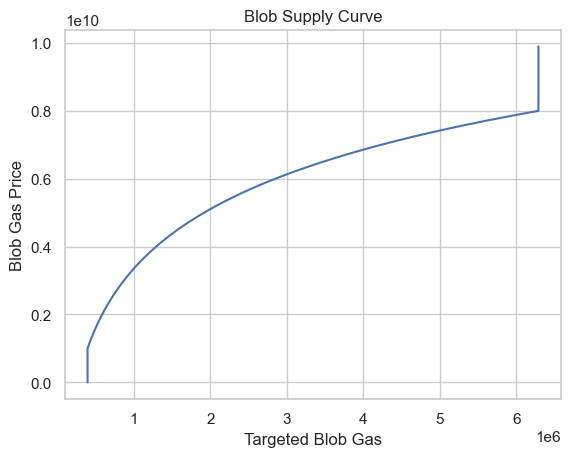

In [5]:
base_fee_values = range(0, BASE_FEE_AT_MAX_TARGET_BLOBS + 2_000_000_000, 100_000_000)
target_blob_values = [get_target_blob_gas_per_block(MIN_TARGET_BLOB_GAS_PER_BLOCK, MAX_TARGET_BLOB_GAS_PER_BLOCK, TARGET_BLOB_UPDATE_FRACTION, base_fee) for base_fee in base_fee_values]

fig, ax = plt.subplots()
ax.plot(target_blob_values, base_fee_values, label="daul-variable EIP-1559")
ax.set_xlabel("Targeted Blob Gas")
ax.set_ylabel("Blob Gas Price")
ax.set_title("Blob Supply Curve")
fig.savefig(f'../img/blob_supply_curve.png')

In [6]:
# Model implementation

def policy_resource_fee(params, substep, state_history, previous_state):
    min_base_fee_per_blob_gas = params['min_base_fee_per_blob_gas']
    blob_base_fee_update_fraction = params['blob_base_fee_update_fraction']

    parent_target_blob_gas = previous_state['target_blob_gas']
    parent_blob_gas_used = previous_state['blob_gas_used']
    parent_excess_blob_gas = previous_state['excess_blob_gas']

    excess_blob_gas = calc_excess_blob_gas(parent_target_blob_gas, parent_excess_blob_gas, parent_blob_gas_used)
    base_fee_per_blob_gas = get_base_fee_per_blob_gas(min_base_fee_per_blob_gas, blob_base_fee_update_fraction, excess_blob_gas)

    return {
        'excess_blob_gas': excess_blob_gas,
        'base_fee_per_blob_gas': base_fee_per_blob_gas
    }

def policy_resource_target(params, substep, state_history, previous_state):
    min_target_blob_gas_per_block = params['min_target_blob_gas_per_block']
    max_target_blob_gas_per_block = params['max_target_blob_gas_per_block']
    target_blob_update_fraction = params['target_blob_update_fraction']

    base_fee_per_blob_gas = previous_state['base_fee_per_blob_gas']

    target_blob_gas = get_target_blob_gas_per_block(
        min_target_blob_gas_per_block,
        max_target_blob_gas_per_block,
        target_blob_update_fraction,
        base_fee_per_blob_gas,
    )

    return {
        'target_blob_gas': target_blob_gas
    }

def policy_resource_usage(params, substep, state_history, previous_state):
    process_blob_gas_used = params['process_blob_gas_used']
    
    run = previous_state['run']
    timestep = previous_state['timestep']

    blob_gas_used = process_blob_gas_used(run, timestep)

    return {
        'blob_gas_used': blob_gas_used
    }

def update_excess_blob_gas(params, substep, state_history, previous_state, policy_input):
    excess_blob_gas = policy_input['excess_blob_gas']
    return ('excess_blob_gas', excess_blob_gas)

def update_base_fee_per_blob_gas(params, substep, state_history, previous_state, policy_input):
    base_fee_per_blob_gas = policy_input['base_fee_per_blob_gas']
    return ('base_fee_per_blob_gas', base_fee_per_blob_gas)

def update_target_blob_gas(params, substep, state_history, previous_state, policy_input):
    target_blob_gas = policy_input['target_blob_gas']
    return ('target_blob_gas', target_blob_gas)

def update_blob_gas_used(params, substep, state_history, previous_state, policy_input):
    blob_gas_used = policy_input['blob_gas_used']
    return ('blob_gas_used', blob_gas_used)

state_update_blocks_for_fixed_supply = [
    {
        'policies': {
            'resource_fee': policy_resource_fee,
        },
        'variables': {
            'excess_blob_gas': update_excess_blob_gas,
            'base_fee_per_blob_gas': update_base_fee_per_blob_gas,
        }
    },
    {
        'policies': {
            'resource_usage': policy_resource_usage,
        },
        'variables': {
            'blob_gas_used': update_blob_gas_used,
        }
    },
]

state_update_blocks_for_elastic_supply = [
    {
        'policies': {
            'resource_fee': policy_resource_fee,
        },
        'variables': {
            'excess_blob_gas': update_excess_blob_gas,
            'base_fee_per_blob_gas': update_base_fee_per_blob_gas,
        }
    },
    {
        'policies': {
            'resource_target': policy_resource_target,
        },
        'variables': {
            'target_blob_gas': update_target_blob_gas,
        }
    },
    {
        'policies': {
            'resource_usage': policy_resource_usage,
        },
        'variables': {
            'blob_gas_used': update_blob_gas_used,
        }
    },
]

initial_state = {
    'target_blob_gas': MIN_TARGET_BLOB_GAS_PER_BLOCK,
    'blob_gas_used': 0,
    'excess_blob_gas': 0,
    'base_fee_per_blob_gas': 1,
}

params = {
    'min_base_fee_per_blob_gas': [MIN_BASE_FEE_PER_BLOB_GAS],
    'blob_base_fee_update_fraction': [BLOB_BASE_FEE_UPDATE_FRACTION],
    'min_target_blob_gas_per_block': [MIN_TARGET_BLOB_GAS_PER_BLOCK],
    'max_target_blob_gas_per_block': [MAX_TARGET_BLOB_GAS_PER_BLOCK],
    'target_blob_update_fraction': [TARGET_BLOB_UPDATE_FRACTION],
    'process_blob_gas_used': [],
}


In [7]:
# Data generation

rng = np.random.default_rng()

def truncated_poisson(lam: int, max_value: int, size: int):
    temp_size = size
    while True:
        temp_size *= 2
        temp = rng.poisson(lam=lam, size=temp_size)
        truncated = temp[temp <= max_value]
        if len(truncated) >= size:
            return truncated[:size]

def create_upward_values(min_value: int, max_value: int, size: int):
    turn_size = size
    delta = (max_value - min_value) / turn_size
    values = []
    for i in range(size):
        if i < turn_size:
            value = min_value + i * delta
            value_int = np.floor(value).astype(int)
            value_decimal = value - value_int
            value_final = rng.choice([value_int, value_int + 1], p=[1 - value_decimal, value_decimal])
            values.append(value_final)
        else:
            values.append(max_value)
    return values

def create_downward_values(min_value: int, max_value: int, size: int):
    turn_size = size
    delta = (max_value - min_value) / turn_size
    values = []
    for i in range(size):
        if i < turn_size:
            values.append(np.round(max_value - i * delta).astype(int))
        else:
            values.append(min_value)
    return values

def create_periodic_values(min_value: int, max_value: int, size: int):
    num_periods = 3
    t = np.linspace(0, 2 * np.pi * num_periods, size, endpoint=False)
    cosine_wave = np.cos(t)
    amplitude = (max_value - min_value) / 2
    offset = (max_value + min_value) / 2
    periodic_values = offset - amplitude * cosine_wave
    return np.floor(periodic_values).astype(int)

def generate_flat_samples(runs: int, timesteps: int, lam: int, max_value: int):
    return [truncated_poisson(lam=lam, max_value=max_value, size=timesteps + 1) * GAS_PER_BLOB for run in range(runs)]

def generate_upward_samples(runs: int, timesteps: int, min_lam: int, max_lam: int, max_value: int):
    return [[truncated_poisson(lam=lam, max_value=max_value, size=1)[0] * GAS_PER_BLOB for lam in create_upward_values(min_lam, max_lam, timesteps + 1)] for run in range(runs)]

def generate_downward_samples(runs: int, timesteps: int, min_lam: int, max_lam: int, max_value: int):
    return [[truncated_poisson(lam=lam, max_value=max_value, size=1)[0] * GAS_PER_BLOB for lam in create_downward_values(min_lam, max_lam, timesteps + 1)] for run in range(runs)]

def generate_periodic_samples(runs: int, timesteps: int, min_lam: int, max_lam: int, max_value: int):
    return [[truncated_poisson(lam=lam, max_value=max_value, size=1)[0] * GAS_PER_BLOB for lam in create_periodic_values(min_lam, max_lam, timesteps + 1)] for run in range(runs)]

def generate_trend_values(min_value: int, max_value: int, size: int):
    values: list[int] = []
    turn_size = size // 5
    delta = (max_value - min_value) / turn_size
    for i in range(size):
        if i < size // 5:
            values.append(min_value)
        elif i < size // 5 * 2:
            index =  i - size // 5
            values.append(np.floor(min_value + delta * index).astype(int))
        elif i < size // 5 * 3:
            values.append(max_value)
        elif i < size // 5 * 4:
            index =  i - size // 5 * 3
            values.append(np.floor(max_value - delta * index).astype(int))
        else:
            values.append(min_value)
    return values

def generate_samples(runs: int, timesteps: int, min_lam: int, max_lam: int, max_value: int):
    return [[truncated_poisson(lam=lam, max_value=max_value, size=1)[0] * GAS_PER_BLOB for lam in generate_trend_values(min_lam, max_lam, timesteps + 1)] for run in range(runs)]


In [8]:
samples_insufficient = generate_flat_samples(RUNS, TIMESTEPS, 1, 72)

timesteps_lower_bound = 5 * 60 * 48
samples_lower_bound = generate_flat_samples(RUNS, timesteps_lower_bound, 3, 72)

timesteps_middle_bound = 5 * 60 * 3
samples_middle_bound = generate_flat_samples(RUNS, timesteps_middle_bound, 36, 72)

timesteps_upper_bound = 5 * 60 * 2
samples_upper_bound = generate_flat_samples(RUNS, timesteps_upper_bound, 48, 72)

timesteps_excessive = int(5 * 60 * 1.2)
samples_excessive = generate_flat_samples(RUNS, timesteps_excessive, 60, 72)

timesteps_periodic = 5 * 60 * 12
samples_periodic = generate_periodic_samples(RUNS, timesteps_periodic, 3, 48, 72)

cases = [
    # {
    #     'name': 'Fixed Blob Target',
    #     'initial_state': {
    #         **initial_state,
    #         'target_blob_gas': MAX_TARGET_BLOB_GAS_PER_BLOCK,
    #     },
    #     'state_update_blocks': state_update_blocks_for_fixed_supply,
    #     'params': {
    #         **params,
    #         'process_blob_gas_used': [lambda run, timestep: samples_upper_bound[run - 1][timestep]],
    #     },
    #     'timesteps': TIMESTEPS,
    #     'runs': RUNS,
    # },
    {
        'name': 'Under insufficient demand',
        'initial_state': {
            **initial_state,
        },
        'state_update_blocks': state_update_blocks_for_elastic_supply,
        'params': {
            **params,
            'process_blob_gas_used': [lambda run, timestep: samples_insufficient[run - 1][timestep]],
        },
        'timesteps': TIMESTEPS,
        'runs': RUNS,
    },
    {
        'name': 'Under lower bound demand',
        'initial_state': {
            **initial_state,
        },
        'state_update_blocks': state_update_blocks_for_elastic_supply,
        'params': {
            **params,
            'process_blob_gas_used': [lambda run, timestep: samples_lower_bound[run - 1][timestep]],
        },
        'timesteps': timesteps_lower_bound,
        'runs': RUNS,
    },
    {
        'name': 'Under the range of target bounds',
        'initial_state': {
            **initial_state,
        },
        'state_update_blocks': state_update_blocks_for_elastic_supply,
        'params': {
            **params,
            'process_blob_gas_used': [lambda run, timestep: samples_middle_bound[run - 1][timestep]],
        },
        'timesteps': timesteps_middle_bound,
        'runs': RUNS,
    },
    {
        'name': 'Under upper bound demand',
        'initial_state': {
            **initial_state,
        },
        'state_update_blocks': state_update_blocks_for_elastic_supply,
        'params': {
            **params,
            'process_blob_gas_used': [lambda run, timestep: samples_upper_bound[run - 1][timestep]],
        },
        'timesteps': timesteps_upper_bound,
        'runs': RUNS,
    },
    {
        'name': 'Under excessive demand',
        'initial_state': {
            **initial_state,
        },
        'state_update_blocks': state_update_blocks_for_elastic_supply,
        'params': {
            **params,
            'process_blob_gas_used': [lambda run, timestep: samples_excessive[run - 1][timestep]],
        },
        'timesteps': timesteps_excessive,
        'runs': RUNS,
    },
    {
        'name': 'Under periodic demand',
        'initial_state': {
            **initial_state,
        },
        'state_update_blocks': state_update_blocks_for_elastic_supply,
        'params': {
            **params,
            'process_blob_gas_used': [lambda run, timestep: samples_periodic[run - 1][timestep]],
        },
        'timesteps': timesteps_periodic,
        'runs': RUNS,
    },
]

In [9]:
# Simulation
def create_simulation(case):
    model = Model(
        initial_state=case['initial_state'],
        state_update_blocks=case['state_update_blocks'],
        params=case['params'],
    )
    simulation = Simulation(
        model=model,
        timesteps=case['timesteps'],
        runs=case['runs'],
    )
    return simulation

simulations = list(map(create_simulation, cases))
experiment = Experiment(simulations=simulations)
experiment.engine = Engine(backend=Backend.PATHOS, drop_substeps=True)
result = experiment.run()

In [10]:
df = pd.DataFrame(result)
df

,target_blob_gas,blob_gas_used,excess_blob_gas,base_fee_per_blob_gas,simulation,subset,run,substep,timestep
0,393216,0,0,1,0,0,1,0,0
1,393216,262144,0,1,0,0,1,3,1
2,393216,0,0,1,0,0,1,3,2
3,393216,131072,0,1,0,0,1,3,3
4,393216,0,0,1,0,0,1,3,4
...,...,...,...,...,...,...,...,...,...
207655,664763,262144,1656042313,2325658833,5,0,10,3,3596
207656,661568,262144,1655639694,2313496248,5,0,10,3,3597
207657,658431,262144,1655240270,2301493032,5,0,10,3,3598
207658,655348,524288,1654843983,2289645633,5,0,10,3,3599


In [11]:
df_excess_blob_gas_stats = df.groupby(['simulation', 'timestep'])['excess_blob_gas'].describe()
df_excess_blob_gas_stats

count          mean           std           min  \
simulation timestep                                                    
0          0          10.0  0.000000e+00  0.000000e+00  0.000000e+00   
           1          10.0  0.000000e+00  0.000000e+00  0.000000e+00   
           2          10.0  0.000000e+00  0.000000e+00  0.000000e+00   
           3          10.0  0.000000e+00  0.000000e+00  0.000000e+00   
           4          10.0  0.000000e+00  0.000000e+00  0.000000e+00   
...                    ...           ...           ...           ...   
5          3596       10.0  1.655113e+09  1.336645e+06  1.652696e+09   
           3597       10.0  1.654810e+09  1.380101e+06  1.652319e+09   
           3598       10.0  1.654534e+09  1.416030e+06  1.651814e+09   
           3599       10.0  1.654170e+09  1.209519e+06  1.652098e+09   
           3600       10.0  1.654070e+09  1.140848e+06  1.652119e+09   

                              25%           50%           75%           max  
simulation timestep                                                          
0          0         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
           1         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
           2         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
           3         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
           4         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
...                           ...           ...           ...           ...  
5          3596      1.654207e+09  1.655171e+09  1.656041e+09  1.656907e+09  
           3597      1.653872e+09  1.654776e+09  1.655606e+09  1.656761e+09  
           3598      1.653730e+09  1.654420e+09  1.655207e+09  1.656615e+09  
           3599      1.653495e+09  1.654059e+09  1.654811e+09  1.655945e+09  
           3600      1.653361e+09  1.653962e+09  1.654647e+09  1.655809e+09  

[20766 rows x 8 columns]

In [12]:
df_base_fee_per_blob_gas_stats = df.groupby(['simulation', 'timestep'])['base_fee_per_blob_gas'].describe()
df_base_fee_per_blob_gas_stats

count          mean           std           min  \
simulation timestep                                                    
0          0          10.0  1.000000e+00  0.000000e+00  1.000000e+00   
           1          10.0  1.000000e+00  0.000000e+00  1.000000e+00   
           2          10.0  1.000000e+00  0.000000e+00  1.000000e+00   
           3          10.0  1.000000e+00  0.000000e+00  1.000000e+00   
           4          10.0  1.000000e+00  0.000000e+00  1.000000e+00   
...                    ...           ...           ...           ...   
5          3596       10.0  2.298003e+09  3.990155e+07  2.226479e+09   
           3597       10.0  2.288953e+09  4.108351e+07  2.215574e+09   
           3598       10.0  2.280783e+09  4.195966e+07  2.201041e+09   
           3599       10.0  2.269880e+09  3.574460e+07  2.209219e+09   
           3600       10.0  2.266904e+09  3.370090e+07  2.209810e+09   

                              25%           50%           75%           max  
simulation timestep                                                          
0          0         1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
           1         1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
           2         1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
           3         1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
           4         1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
...                           ...           ...           ...           ...  
5          3596      2.270745e+09  2.299436e+09  2.325626e+09  2.352011e+09  
           3597      2.260854e+09  2.287614e+09  2.312478e+09  2.347521e+09  
           3598      2.256699e+09  2.277028e+09  2.300488e+09  2.343064e+09  
           3599      2.249768e+09  2.266362e+09  2.288653e+09  2.322727e+09  
           3600      2.245857e+09  2.263496e+09  2.283785e+09  2.318590e+09  

[20766 rows x 8 columns]

In [13]:
df_target_blob_gas_stats = df.groupby(['simulation', 'timestep'])['target_blob_gas'].describe()
df_target_blob_gas_stats

count      mean           std       min        25%  \
simulation timestep                                                       
0          0          10.0  393216.0      0.000000  393216.0  393216.00   
           1          10.0  393216.0      0.000000  393216.0  393216.00   
           2          10.0  393216.0      0.000000  393216.0  393216.00   
           3          10.0  393216.0      0.000000  393216.0  393216.00   
           4          10.0  393216.0      0.000000  393216.0  393216.00   
...                    ...       ...           ...       ...        ...   
5          3596       10.0  657594.9  10370.965127  639155.0  650461.50   
           3597       10.0  655246.2  10651.751424  636400.0  647918.50   
           3598       10.0  653132.8  10834.670746  632748.0  646857.75   
           3599       10.0  650296.1   9206.218496  634800.0  645079.50   
           3600       10.0  649523.6   8676.183124  634949.0  644079.75   

                          50%       75%       max  
simulation timestep                                
0          0         393216.0  393216.0  393216.0  
           1         393216.0  393216.0  393216.0  
           2         393216.0  393216.0  393216.0  
           3         393216.0  393216.0  393216.0  
           4         393216.0  393216.0  393216.0  
...                       ...       ...       ...  
5          3596      657895.0  664754.5  671738.0  
           3597      654821.5  661301.5  670544.0  
           3598      652081.0  658169.0  669362.0  
           3599      649333.5  655090.5  663992.0  
           3600      648598.0  653829.0  662904.0  

[20766 rows x 8 columns]

In [14]:
df_blob_gas_used_stats = df.groupby(['simulation', 'timestep'])['blob_gas_used'].describe()
df_blob_gas_used_stats

count      mean            std       min       25%  \
simulation timestep                                                       
0          0          10.0       0.0       0.000000       0.0       0.0   
           1          10.0  131072.0  138162.019158       0.0       0.0   
           2          10.0  157286.4  161123.217481       0.0       0.0   
           3          10.0  157286.4  120446.855869       0.0  131072.0   
           4          10.0  117964.8  114765.992529       0.0       0.0   
...                    ...       ...            ...       ...       ...   
5          3596       10.0  353894.4  223207.572975       0.0  262144.0   
           3597       10.0  380108.8  242866.666160  131072.0  262144.0   
           3598       10.0  288358.4  288490.765580       0.0  131072.0   
           3599       10.0  550502.4  319868.199986  131072.0  393216.0   
           3600       10.0  353894.4  223207.572975       0.0  163840.0   

                          50%       75%        max  
simulation timestep                                 
0          0              0.0       0.0        0.0  
           1         131072.0  229376.0   393216.0  
           2         131072.0  262144.0   393216.0  
           3         131072.0  229376.0   393216.0  
           4         131072.0  229376.0   262144.0  
...                       ...       ...        ...  
5          3596      327680.0  491520.0   786432.0  
           3597      327680.0  393216.0   917504.0  
           3598      196608.0  458752.0   917504.0  
           3599      524288.0  655360.0  1048576.0  
           3600      393216.0  491520.0   655360.0  

[20766 rows x 8 columns]

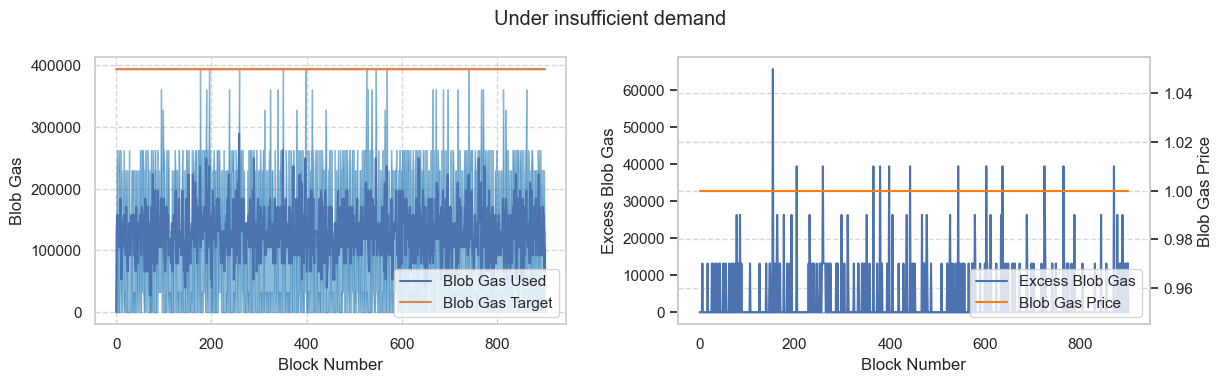

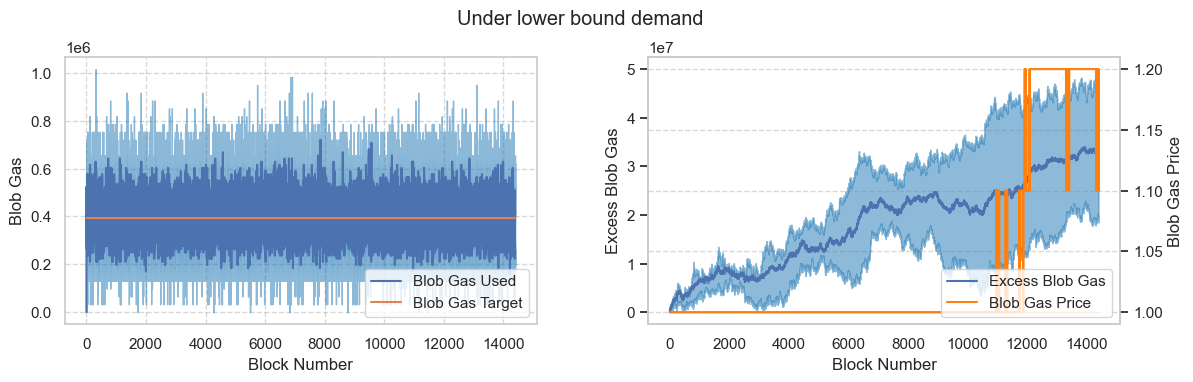

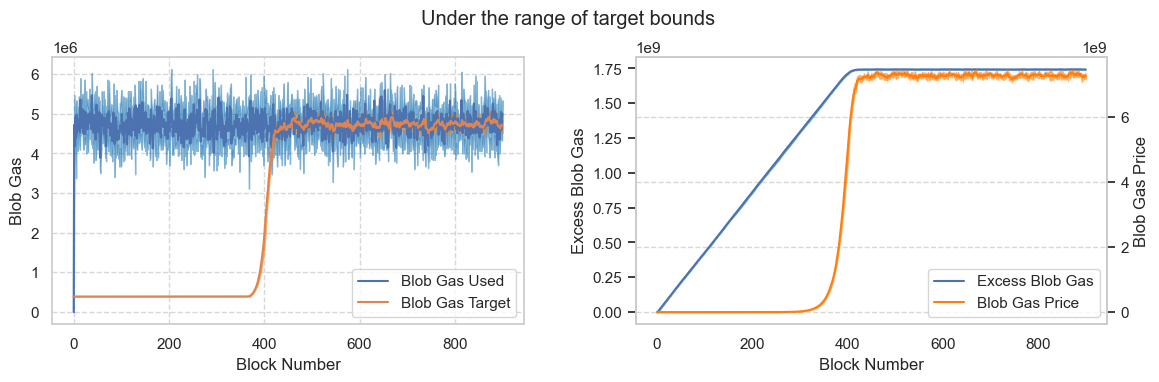

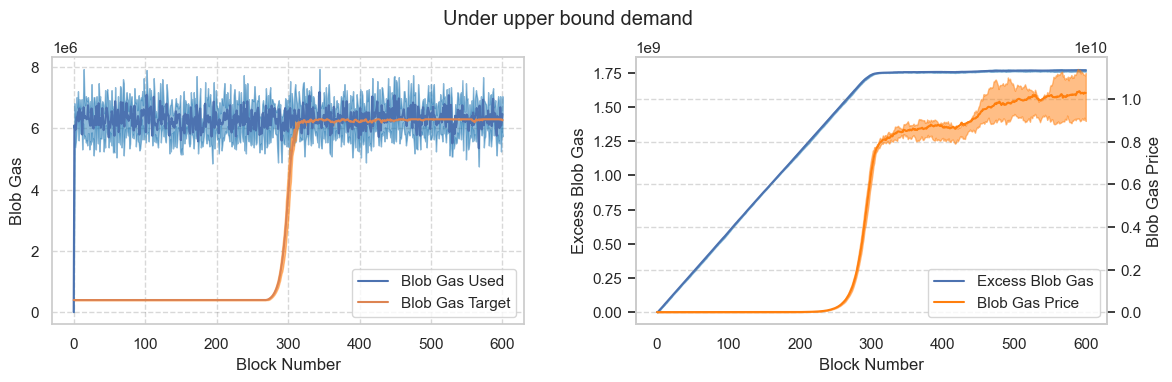

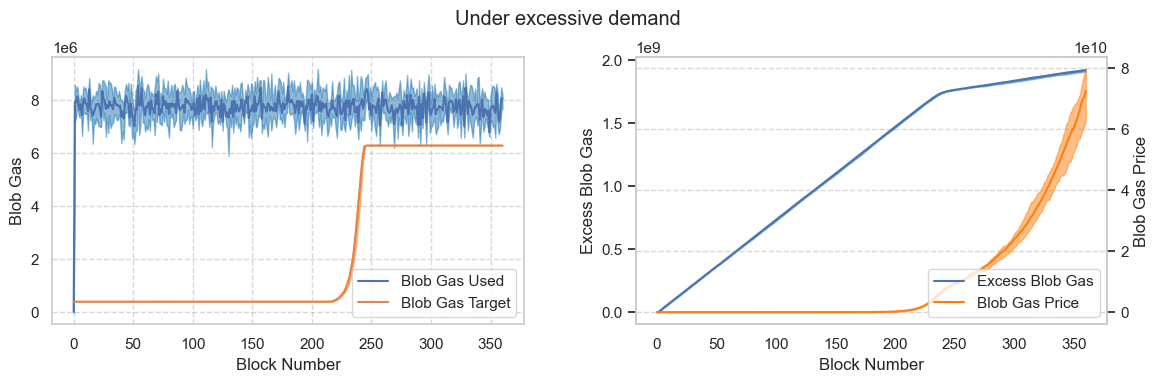

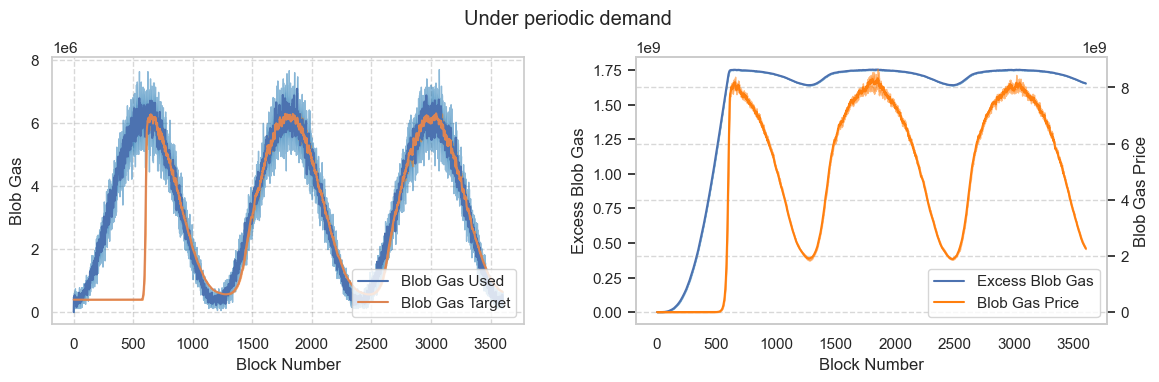

In [15]:
for index, case in enumerate(cases):
    blob_gas_used = df_blob_gas_used_stats.loc[index]
    target_blob_gas = df_target_blob_gas_stats.loc[index]
    excess_blob_gas = df_excess_blob_gas_stats.loc[index]
    base_fee_per_blob_gas = df_base_fee_per_blob_gas_stats.loc[index]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.tight_layout(pad=3, w_pad=4, h_pad=3)
    fig.suptitle(case['name'])

    ax1.plot(blob_gas_used.index, blob_gas_used['mean'].values, label='Blob Gas Used')
    ax1.fill_between(blob_gas_used.index, blob_gas_used['25%'].values, blob_gas_used['75%'].values, color='tab:blue', alpha=0.5)
    ax1.plot(target_blob_gas.index, target_blob_gas['mean'].values, label='Blob Gas Target')
    ax1.fill_between(target_blob_gas.index, target_blob_gas['25%'].values, target_blob_gas['75%'].values, color='tab:orange', alpha=0.5)
    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle='--', color='gray', alpha=0.3)
    ax1.set_xlabel('Block Number')
    ax1.set_ylabel('Blob Gas')


    line_excess_blob_gas = ax2.plot(excess_blob_gas.index, excess_blob_gas['mean'].values, label='Excess Blob Gas')
    ax2.fill_between(excess_blob_gas.index, excess_blob_gas['25%'].values, excess_blob_gas['75%'].values, color='tab:blue', alpha=0.5)
    ax2.grid(False)
    ax2.set_xlabel('Block Number')
    ax2.set_ylabel('Excess Blob Gas')

    ax3 = ax2.twinx()
    line_base_fee = ax3.plot(base_fee_per_blob_gas.index, base_fee_per_blob_gas['mean'].values, label='Blob Gas Price', color='tab:orange')
    ax3.fill_between(base_fee_per_blob_gas.index, base_fee_per_blob_gas['25%'].values, base_fee_per_blob_gas['75%'].values, color='tab:orange', alpha=0.5)
    ax3.legend(handles=line_excess_blob_gas + line_base_fee, loc='lower right')
    ax3.grid(True, linestyle='--', color='gray', alpha=0.3)
    ax3.set_ylabel('Blob Gas Price')
    

    fig.savefig(f'../img/{to_snake_case(case["name"].lower())}.png')

In [17]:
df_history_data = pd.read_csv('../data/blocks_1week_after_pectra.csv')

df_history_data['timestamp'] = pd.to_datetime(df_history_data['timestamp'])

df_history_data = df_history_data.set_index('timestamp')

timesteps_history = 50400
data = df_history_data[:timesteps_history+1]
data

,number,blobGasUsed,excessBlobGas,blobGasPrice
timestamp,,,,
2025-05-07 10:05:11+00:00,22431084,1179648,50462720,23789
2025-05-07 10:05:23+00:00,22431085,1048576,50855936,25732
2025-05-07 10:05:35+00:00,22431086,0,51118080,27115
2025-05-07 10:05:47+00:00,22431087,0,50331648,23174
2025-05-07 10:06:11+00:00,22431088,524288,49545216,19806
...,...,...,...,...
2025-05-14 12:43:11+00:00,22481480,1179648,131072,1
2025-05-14 12:43:23+00:00,22481481,0,524288,1
2025-05-14 12:43:35+00:00,22481482,0,0,1


In [18]:
samples_history = list(data['blobGasUsed'])

config_history = {
    'name': 'Elastic Blob Supply under historical data',
    'initial_state': {
        **initial_state,
        'blob_gas_used': data['blobGasUsed'].iloc[0],
        'excess_blob_gas': data['excessBlobGas'].iloc[0],
        'base_fee_per_blob_gas': data['blobGasPrice'].iloc[0],
    },
    'state_update_blocks': state_update_blocks_for_elastic_supply,
    'params': {
        **params,
        'process_blob_gas_used': [lambda run, timestep: samples_history[timestep]],
    },
    'timesteps': timesteps_history,
    'runs': 1,
}

model_history = Model(
    initial_state=config_history['initial_state'],
    state_update_blocks=config_history['state_update_blocks'],
    params=config_history['params'],
)

simulation_history = Simulation(
    model=model_history,
    timesteps=config_history['timesteps'],
    runs=config_history['runs'],
)

experiment_history = Experiment(simulations=[simulation_history])
experiment_history.engine = Engine(backend=Backend.PATHOS, drop_substeps=True)
result_history = experiment_history.run()

In [19]:
df_history = pd.DataFrame(result_history)
df_history

,target_blob_gas,blob_gas_used,excess_blob_gas,base_fee_per_blob_gas,simulation,subset,run,substep,timestep
0,393216,1179648,50462720,23789,0,0,1,0,0
1,393216,1048576,51249152,1,0,0,1,3,1
2,393216,0,51904512,1,0,0,1,3,2
3,393216,0,51511296,1,0,0,1,3,3
4,393216,524288,51118080,1,0,0,1,3,4
...,...,...,...,...,...,...,...,...,...
50396,651531,1179648,1654347829,2274898550,0,0,1,3,50396
50397,655596,0,1654875946,2290598934,0,0,1,3,50397
50398,650558,0,1654220350,2271124880,0,0,1,3,50398
50399,645640,1179648,1653569792,2251964139,0,0,1,3,50399


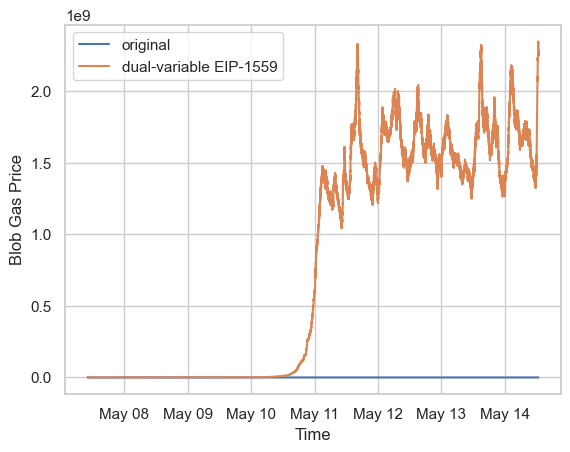

In [20]:
fig, ax = plt.subplots()
ax.plot(data.index, data['blobGasPrice'], label='original')
ax.plot(data.index, df_history['base_fee_per_blob_gas'], label='dual-variable EIP-1559')
ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Blob Gas Price')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
fig.savefig(f'../img/simulation_based_on_historical_data.png')